<h1><center> <span style="color:blue">Segmenting and Clustering Neighborhoods in Toronto<br> Part III </span><h1>
    

<h3><center>The purpose of this notebook is to scrape code from a Wikipedia page, about Toronto Neighbourhoods. Then put it into a Dataframe. <br> After this the Longtitude and Latitude using the Geocoder Python package. Finally the nighbourhoods were segmented using the k-means method and the Foursqaure API <center><h3>

In [10]:
#imports
import pandas as pd
import numpy as np
import requests
from requests import get 
import lxml.html as lh
import geocoder
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [11]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'           #the website which we are using for our data 
response=get(url)                                                               #request the content of the webpage from the server and store it in the variable 'respose'

In [12]:
doc = lh.fromstring(response.content)                                           #storing the contents of website in a document
tr_elements = doc.xpath('//tr')                                                 #extracting the data stored between <tr></tr> tags (which define a table)
#create an empty list to store the table data in 
col=[]
i=0
#stroing the headers
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))
    
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    #this is to ensure that each row has the same length
    if len(T)!=3:
        break
    i=0
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #if there is any numerical data convert it into integers 
            try:
                data=int(data)
            except:
                pass
        #Append the data
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

In [13]:
#create the dataframe 
Dict={title:column for (title,column) in col}
df_neighbourhood=pd.DataFrame(Dict)
print(df_neighbourhood.shape)
df_neighbourhood.head()

(287, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned\n
1,M2A,Not assigned,Not assigned\n
2,M3A,North York,Parkwoods\n
3,M4A,North York,Victoria Village\n
4,M5A,Downtown Toronto,Harbourfront\n


 <h3><span style="color:blue"> DATA CLEANING </span><h3>

In [14]:
#removing all the columns which do not have an assigned Borough
df_neighbourhood=df_neighbourhood[df_neighbourhood.Borough!="Not assigned"]
print(df_neighbourhood.shape)
df_neighbourhood=df_neighbourhood.reset_index(drop=True)       #reset the index 
df_neighbourhood.rename(columns={'Neighbourhood\n':'Neighbourhood'},inplace=True)    #renaming column to replace '\n' character
df_neighbourhood['Neighbourhood'] = df_neighbourhood['Neighbourhood'].map(lambda x: x.rstrip('\n'))   #removing the '\n' that appears after the neighbourhoods
df_neighbourhood.head()

(210, 3)


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [15]:
df_neighbourhood=df_neighbourhood.groupby('Postcode').agg(lambda x: ','.join(set(x)))   #groupby postcode and combine rows with same postcode 
df_neighbourhood=df_neighbourhood.reset_index(drop=False)
df_neighbourhood.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"West Hill,Guildwood,Morningside"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [16]:
#if a cell as an assigned Borough but not neighbourhood then the burough becomes thw neighbourhood 
df_neighbourhood['Neighbourhood']=np.where(df_neighbourhood['Neighbourhood']=='Not assigned',df_neighbourhood['Borough'],df_neighbourhood['Neighbourhood'])

In [17]:
df_neighbourhood.shape

(103, 3)

In [18]:
#downlaod longtitude and latitude data 
!wget -q -O 'longandlat_data.csv' https://cocl.us/Geospatial_data
long_lat_df=pd.read_csv('longandlat_data.csv')
long_lat_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [19]:
#append the logtitude and latitude columns to df_neighbourhood 
df_neighbourhood['Latitude']=long_lat_df['Latitude']
df_neighbourhood['Longitude']=long_lat_df['Longitude']
df_neighbourhood.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"West Hill,Guildwood,Morningside",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<h3><span style="color:blue">NEIGHBOURHOOD SEGMENTATION</span><h3> 

<h3> Defining the Foursqaure API credientials and Version <h3>

In [36]:
# The code was removed by Watson Studio for sharing.

<h3> Creating the geolocater instance <h3>

In [21]:
address='Toronto, TO'
geolocater=Nominatim(user_agent="toronto_explorer")
location = geolocater.geocode(address)                     
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


<h3> Creating a map of Toronto and adding markers to represent each nieghbourhood <h3>

In [22]:
toronto_map=folium.Map(location=[latitude,longitude],zoom_start=10)

for lat,long,borough,neighbourhood in zip(df_neighbourhood['Latitude'],df_neighbourhood['Longitude'],df_neighbourhood['Borough'],df_neighbourhood['Neighbourhood']):
                label='{},{}'.format(neighbourhood,borough)
                label=folium.Popup(label,parse_html=True)
                folium.CircleMarker(
                [lat,long],
                raduis=5,
                popup=label,
                color='green',
                fill=True,
                fill_color='green',
                fill_opacity=0.6,
                parse_html=True
                ).add_to(toronto_map)
display(toronto_map)

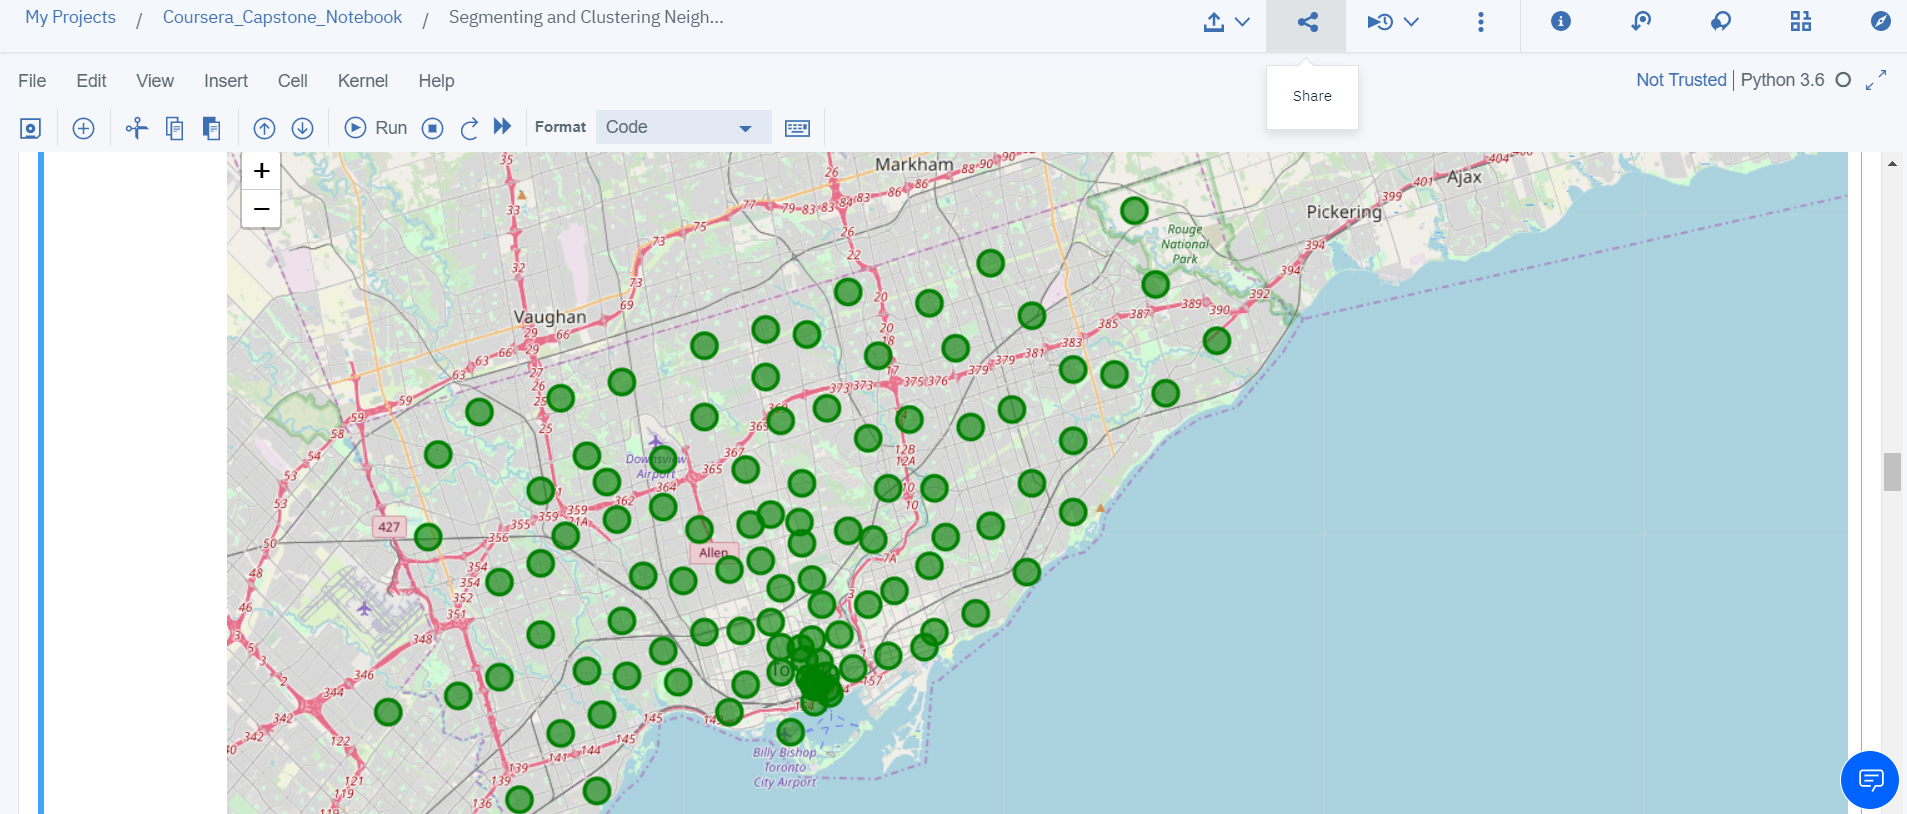

<h3> Exploring Neighbourhoods in Toronto <h3>

 Extracting the top 100 venues from each neighbourhood and storing the information in a dataframe

In [23]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # retrun only the venue name, corrdinates and catagoery
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)        

In [24]:
toronto_venues = getNearbyVenues(names=df_neighbourhood['Neighbourhood'],
                                   latitudes=df_neighbourhood['Latitude'],
                                   longitudes=df_neighbourhood['Longitude']
                                  )


In [25]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"West Hill,Guildwood,Morningside",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"West Hill,Guildwood,Morningside",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"West Hill,Guildwood,Morningside",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


<h3> Analyzing Each Neighbourhood <h3>

In [26]:
#use one hot encoding
toronto_venues_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_venues_onehot['Neighborhood'] = toronto_venues['Neighborhood']            #adding the neighbourhood column back
#make the neighbourhood column the first column
fixed_columns = [toronto_venues_onehot.columns[-1]] + list(toronto_venues_onehot.columns[:-1])
toronto_venues_onehot = toronto_venues_onehot[fixed_columns]
toronto_venues_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next we will group the rows by Nieghbourhood and take the mean frequency of occurance of each catagoery 

In [27]:
toronto_grouped = toronto_venues_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,"Alderwood,Long Branch",0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,"Bathurst Quay,King and Spadina,Railway Lands,H...",0.0,0.0,0.0,0.066667,0.066667,0.066667,0.133333,0.133333,0.133333,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,Bayview Village,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0


Now we will find the top 5 venues for each neighbourhood

In [28]:
for hood in toronto_grouped['Neighborhood']:
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

In [29]:
def return_most_common_venues(row, num_top_venues):               #function that will sort the venues in desecnding order 
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Thai Restaurant,Steakhouse,Bakery,Restaurant,Salad Place,Burger Joint,Sushi Restaurant,Asian Restaurant
1,Agincourt,Latin American Restaurant,Lounge,Sandwich Place,Breakfast Spot,Women's Store,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant
2,"Alderwood,Long Branch",Pizza Place,Gym,Skating Rink,Pharmacy,Pub,Sandwich Place,Coffee Shop,Gay Bar,General Entertainment,Doner Restaurant
3,"Bathurst Quay,King and Spadina,Railway Lands,H...",Airport Lounge,Airport Terminal,Airport Service,Boat or Ferry,Coffee Shop,Bar,Harbor / Marina,Sculpture Garden,Airport Gate,Airport Food Court
4,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Women's Store


<h2><span style="color:blue"> Clustering Neighbourhoods</span> <h2>

In [31]:
k=100
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)

Now we create a new data frame with the clusters added

In [32]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_w_clusters = df_neighbourhood

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_w_clusters = toronto_w_clusters.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
toronto_w_clusters['Cluster Labels'] = toronto_w_clusters['Cluster Labels'].fillna("99").astype(int)
toronto_w_clusters['Cluster Labels'] = toronto_w_clusters['Cluster Labels'].astype('int32')

Now we will display the results on the map

In [35]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_w_clusters['Latitude'], toronto_w_clusters['Longitude'], toronto_w_clusters['Neighbourhood'], toronto_w_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
display(map_clusters)

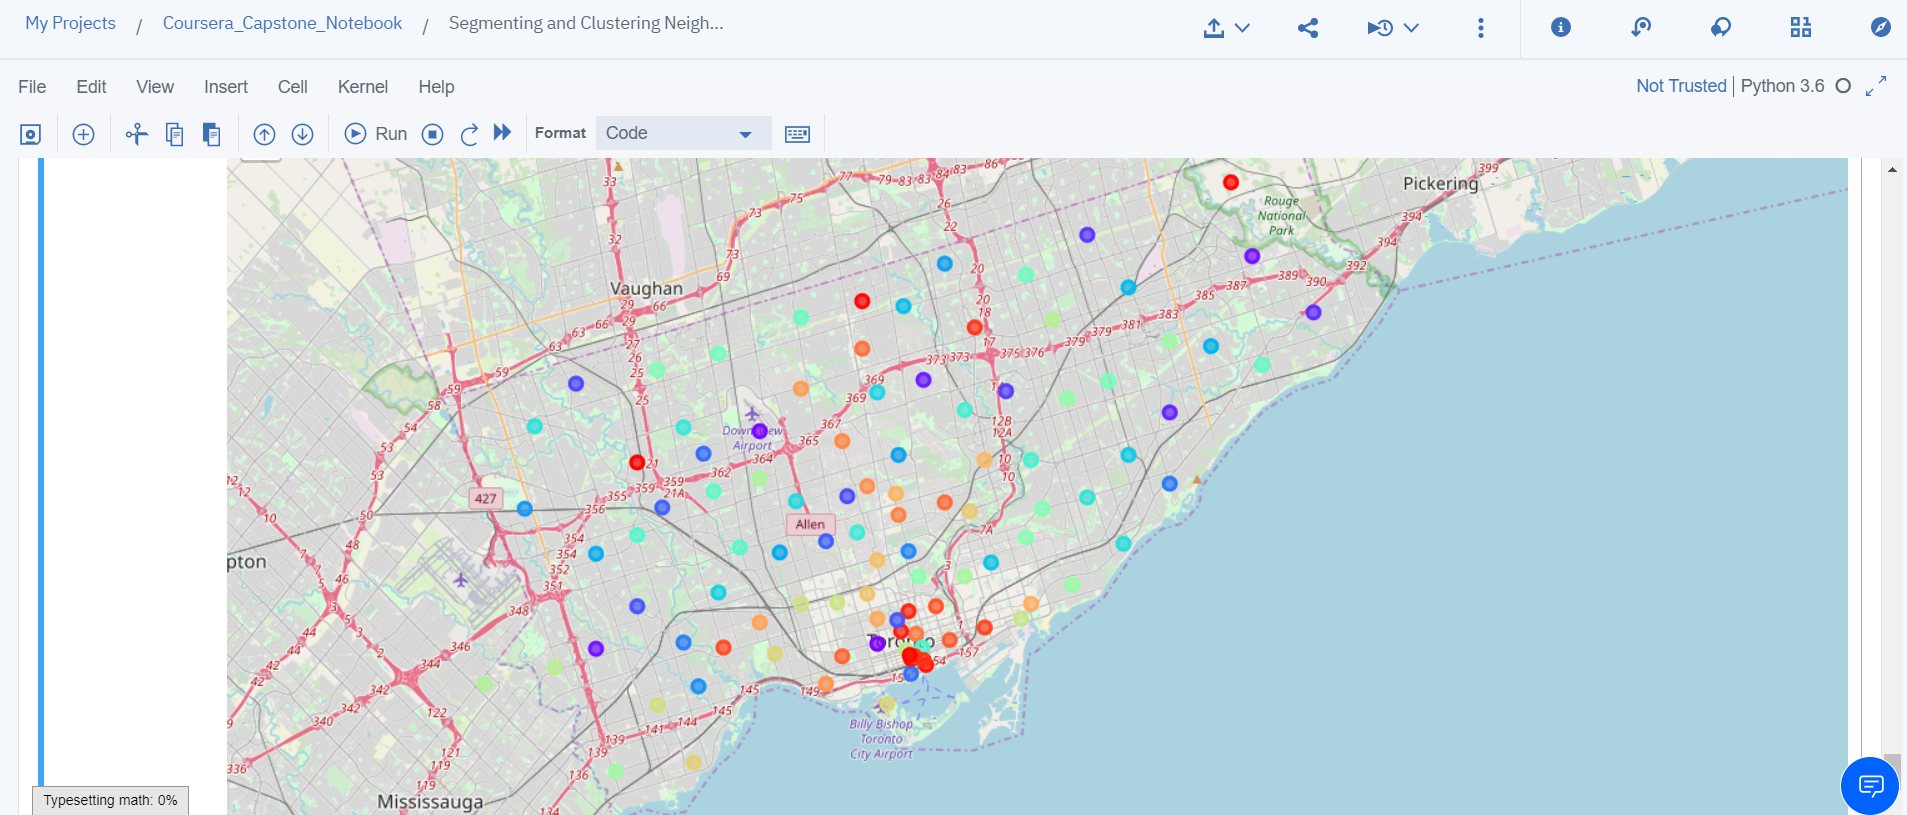